In [1]:
# ISLR material, Original R to Python adaptation by Jordi Warmenhoven
# Subsequent Adaptation from http://www.science.smith.edu/~jcrouser/SDS293/
# Further simplifications and adaptions done above those.

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import itertools
import statsmodels.api as sm
import matplotlib.pyplot as plt

C:\Apps\Dir\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Model selection using the Validation Set Approach

In [3]:
df = pd.read_csv('Hitters.csv')
df = df.dropna().drop('Player', axis=1)
dummies = pd.get_dummies(df[['League', 'Division', 'NewLeague']])
y = pd.DataFrame(df.Salary)
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')
X = pd.concat([X_, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)

In [4]:
np.random.seed(seed=12)
train = np.random.choice([True, False], size = len(y), replace = True)
test = np.invert(train)

In [5]:
def processSubset(feature_set, X_train, y_train, X_test, y_test):
    model = sm.OLS(y_train,X_train[list(feature_set)])
    regr = model.fit()
    RSS = ((regr.predict(X_test[list(feature_set)]) - y_test) ** 2).sum()
    return {"model":regr, "RSS":RSS}

In [6]:
def forward(predictors, X_train, y_train, X_test, y_test):
    results = []
    remaining_predictors = [p for p in X_train.columns if p not in predictors]
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p], X_train, y_train, X_test, y_test))
    models = pd.DataFrame(results)
    best_model = models.loc[models['RSS'].idxmin()]
    return best_model

In [7]:
models_train = pd.DataFrame(columns=["RSS", "model"])
predictors = []
for i in range(1,len(X.columns)+1):    
    models_train.loc[i] = forward(predictors, X[train], y[train]["Salary"], X[test], y[test]["Salary"])
    predictors = models_train.loc[i]["model"].model.exog_names

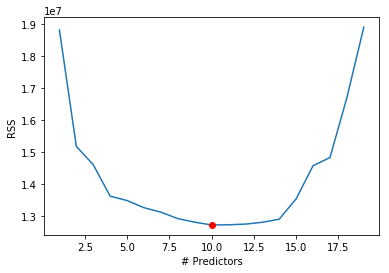

In [8]:
plt.plot(models_train["RSS"])
plt.xlabel('# Predictors')
plt.ylabel('RSS')
plt.plot(models_train["RSS"].idxmin(), models_train["RSS"].min(), "or")
plt.show()

In [9]:
models_test = pd.DataFrame(columns=["RSS", "model"])
predictors = []
for i in range(1,11):    
    models_test.loc[i] = forward(predictors, X[test], y[test]["Salary"], X[test], y[test]["Salary"])
    predictors = models_test.loc[i]["model"].model.exog_names

In [10]:
print(models_train.loc[10, "model"].model.exog_names)
print(models_test.loc[10, "model"].model.exog_names)

['Walks', 'CRBI', 'Hits', 'Division_W', 'CWalks', 'CRuns', 'AtBat', 'League_N', 'CHits', 'Runs']
['Walks', 'CRBI', 'Assists', 'Division_W', 'CWalks', 'CRuns', 'PutOuts', 'Errors', 'League_N', 'CHmRun']


### Model selection using Cross-Validation

In [11]:
k = 10
np.random.seed(seed=1)
folds = np.random.choice(k, size = len(y), replace = True)
cv_errors = pd.DataFrame(columns=range(1,k+1), index=range(1,20))
cv_errors = cv_errors.fillna(0)

In [12]:
models_cv = pd.DataFrame(columns=["RSS", "model"])
for j in range(1,k+1):
    predictors = []
    for i in range(1,len(X.columns)+1):    
        models_cv.loc[i] = forward(predictors, X[folds != (j-1)], y[folds != (j-1)]["Salary"], X[folds == (j-1)], y[folds == (j-1)]["Salary"])
        cv_errors[j][i] = models_cv.loc[i]["RSS"]
        predictors = models_cv.loc[i]["model"].model.exog_names

In [13]:
cv_errors

,1,2,3,4,5,6,7,8,9,10
1,3107900,3212304,4840103,2475453,3750302,1551976,1827366,9115194,1370720,2204862
2,2354036,2247881,3414444,1642455,3160950,1250564,1567469,8520751,1081052,1856304
3,2148733,2012864,3009435,1566581,2775618,907304,1260460,8456576,969784,1674333
4,1946031,1870511,2630784,1521525,2618750,805135,1143882,8331746,857553,1618265
5,1850398,1605148,2537690,1502728,2608466,776171,1124174,8221957,793919,1574253
6,1778324,1574266,2498621,1482575,2632055,776163,1115741,8196969,781235,1534220
7,1761111,1524413,2452303,1480345,2661104,779716,1104388,8171959,776457,1503831
8,1733230,1529625,2418943,1477510,2660654,803859,1100753,7449396,774589,1536790
9,1773705,1607919,2381843,1504519,2677002,821629,1096925,7136283,774616,1542746
10,1865909,1682293,2378624,1528102,2597881,854997,1136162,7059485,775993,1597314


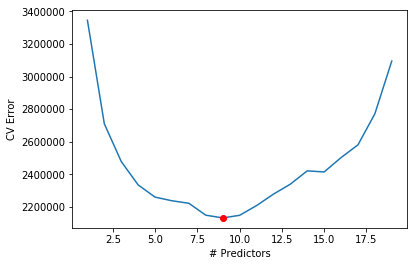

In [14]:
cv_mean = cv_errors.apply(np.mean, axis=1)
plt.plot(cv_mean)
plt.xlabel('# Predictors')
plt.ylabel('CV Error')
plt.plot(cv_mean.idxmin(), cv_mean.min(), "or")
plt.show()

In [15]:
print(models_cv.loc[9, "model"].summary())

                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.685
Model:                            OLS   Adj. R-squared:                  0.672
Method:                 Least Squares   F-statistic:                     54.56
Date:                Sat, 19 May 2018   Prob (F-statistic):           8.32e-52
Time:                        19:12:41   Log-Likelihood:                -1737.9
No. Observations:                 235   AIC:                             3494.
Df Residuals:                     226   BIC:                             3525.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Hits           5.1036      2.325      2.195      0.0

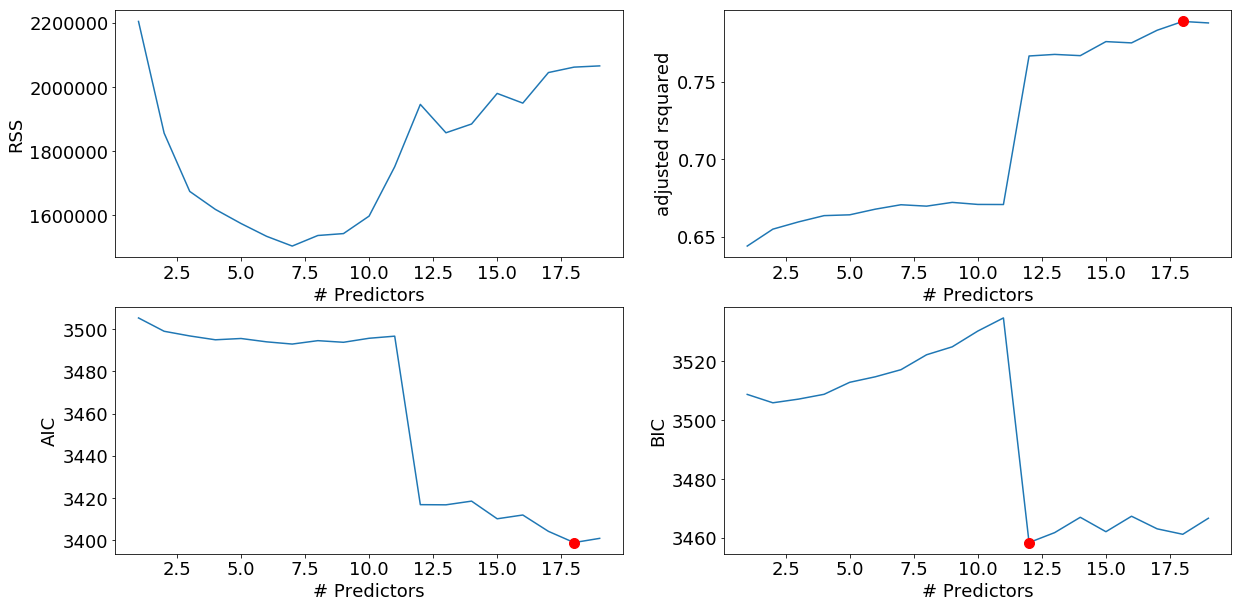

In [16]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

plt.subplot(2, 2, 1)
plt.plot(models_cv["RSS"])
plt.xlabel('# Predictors')
plt.ylabel('RSS')
rsquared_adj = models_cv.apply(lambda row: row[1].rsquared_adj, axis=1)

plt.subplot(2, 2, 2)
plt.plot(rsquared_adj)
plt.plot(rsquared_adj.idxmax(), rsquared_adj.max(), "or")
plt.xlabel('# Predictors')
plt.ylabel('adjusted rsquared')
aic = models_cv.apply(lambda row: row[1].aic, axis=1)

plt.subplot(2, 2, 3)
plt.plot(aic)
plt.plot(aic.idxmin(), aic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('AIC')
bic = models_cv.apply(lambda row: row[1].bic, axis=1)

plt.subplot(2, 2, 4)
plt.plot(bic)
plt.plot(bic.idxmin(), bic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('BIC')

plt.show()